### Import libraries

In [5]:
import torch
import numpy as np
import torch.nn as nn

from tqdm import tqdm
from torch.utils.data import DataLoader

from models.bisenet.build_bisenet import BiSeNet
from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
from utils import fast_hist, per_class_iou

### Import target and source datasets

In [2]:
# Source domain GTA5
source_dataset = GTA5(root_dir='datasets/GTA5')
source_loader = DataLoader(source_dataset, batch_size=3, shuffle=True, num_workers=3)

# Target domain Cityscapes
target_dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
target_loader = DataLoader(target_dataset, batch_size=3, shuffle=True, num_workers=3)

### Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_classes, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.classifier = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))
        x = self.classifier(x)
        return self.sigmoid(x)


### Training Loop

In [4]:
# Set the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Initialize the discriminator and the optimizer
discriminator = Discriminator(num_classes=19).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
optimizer_g = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define the loss function
criterion_seg = nn.CrossEntropyLoss(ignore_index=255)

for epoch in range(50):
    # Create a progress bar
    pbar = tqdm(zip(source_loader, target_loader), total=len(source_loader))
    for source_data, target_data in pbar:
        # Extract source and target images and labels
        src_images, src_labels = source_data
        tgt_images, _ = target_data
        # Move the images and labels to the device
        src_images, src_labels = src_images.to(device), src_labels.to(device)
        tgt_images = tgt_images.to(device)

        # Forward pass through the segmentation network
        src_pred = model(src_images)[0]
        tgt_pred = model(tgt_images)[0]
        
        # Compute segmentation loss on source domain
        seg_loss = criterion_seg(src_pred, src_labels)

        # Train discriminator with source domain predictions (label 1) and target domain predictions (label 0)
        optimizer_d.zero_grad()
        # Detach the source and target predictions to avoid backpropagating through the segmentation network
        src_out_d = discriminator(src_pred.detach())
        tgt_out_d = discriminator(tgt_pred.detach())
        
        # Compute the discriminator loss
        # We use the binary cross-entropy loss here which is equivalent to the negative log likelihood loss
        d_loss_src = nn.BCELoss()(src_out_d, torch.ones_like(src_out_d))
        d_loss_tgt = nn.BCELoss()(tgt_out_d, torch.zeros_like(tgt_out_d))
        d_loss = (d_loss_src + d_loss_tgt) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train segmentation network with adversarial loss to fool the discriminator
        optimizer_g.zero_grad()
        tgt_out_d = discriminator(tgt_pred)
        g_loss_adv = nn.BCELoss()(tgt_out_d, torch.ones_like(tgt_out_d))
        total_loss = seg_loss + g_loss_adv
        total_loss.backward(retain_graph=True)  # Retain graph here if you need to retain it for further operations
        optimizer_g.step()

    print(f"Epoch [{epoch}/{50}], Seg Loss: {seg_loss.item():.4f}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss_adv.item():.4f}")

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_gta5_adapted.pth')


 63%|██████▎   | 524/834 [02:24<01:25,  3.63it/s]


Epoch [0/50], Seg Loss: 0.3737, D Loss: 0.6710, G Loss: 0.6960


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [1/50], Seg Loss: 0.3183, D Loss: 0.6437, G Loss: 0.8683


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [2/50], Seg Loss: 0.2875, D Loss: 0.6459, G Loss: 0.7921


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [3/50], Seg Loss: 0.3627, D Loss: 0.6488, G Loss: 0.7743


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [4/50], Seg Loss: 0.2820, D Loss: 0.6846, G Loss: 0.8155


 63%|██████▎   | 524/834 [02:23<01:25,  3.65it/s]


Epoch [5/50], Seg Loss: 0.4601, D Loss: 0.6937, G Loss: 0.6269


 63%|██████▎   | 524/834 [02:23<01:25,  3.64it/s]


Epoch [6/50], Seg Loss: 0.3114, D Loss: 0.6679, G Loss: 0.7564


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [7/50], Seg Loss: 0.2537, D Loss: 0.6456, G Loss: 0.7488


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [8/50], Seg Loss: 0.2764, D Loss: 0.6452, G Loss: 0.7963


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [9/50], Seg Loss: 0.2175, D Loss: 0.6756, G Loss: 0.8011


 63%|██████▎   | 524/834 [02:23<01:25,  3.65it/s]


Epoch [10/50], Seg Loss: 0.1762, D Loss: 0.6763, G Loss: 0.6715


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [11/50], Seg Loss: 0.3480, D Loss: 0.6595, G Loss: 0.9789


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [12/50], Seg Loss: 0.1779, D Loss: 0.6533, G Loss: 0.9117


 63%|██████▎   | 524/834 [02:23<01:25,  3.64it/s]


Epoch [13/50], Seg Loss: 0.2184, D Loss: 0.6129, G Loss: 0.9486


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [14/50], Seg Loss: 0.1598, D Loss: 0.6571, G Loss: 0.8305


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [15/50], Seg Loss: 0.2371, D Loss: 0.6878, G Loss: 0.8407


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [16/50], Seg Loss: 0.1787, D Loss: 0.6587, G Loss: 0.8183


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [17/50], Seg Loss: 0.1961, D Loss: 0.6599, G Loss: 0.7872


 63%|██████▎   | 524/834 [02:23<01:25,  3.65it/s]


Epoch [18/50], Seg Loss: 0.2353, D Loss: 0.6813, G Loss: 1.1028


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [19/50], Seg Loss: 0.2307, D Loss: 0.6545, G Loss: 0.7033


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [20/50], Seg Loss: 0.1749, D Loss: 0.6639, G Loss: 0.9519


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [21/50], Seg Loss: 0.2008, D Loss: 0.6541, G Loss: 0.8393


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [22/50], Seg Loss: 0.1890, D Loss: 0.6189, G Loss: 0.8660


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [23/50], Seg Loss: 0.1902, D Loss: 0.5886, G Loss: 1.0485


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [24/50], Seg Loss: 0.1372, D Loss: 0.6706, G Loss: 0.9081


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [25/50], Seg Loss: 0.1947, D Loss: 0.6623, G Loss: 0.7791


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [26/50], Seg Loss: 0.1695, D Loss: 0.7032, G Loss: 0.8321


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [27/50], Seg Loss: 0.1835, D Loss: 0.6505, G Loss: 0.7907


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [28/50], Seg Loss: 0.2748, D Loss: 0.6695, G Loss: 0.8676


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [29/50], Seg Loss: 0.2185, D Loss: 0.6489, G Loss: 0.7257


 63%|██████▎   | 524/834 [02:23<01:25,  3.65it/s]


Epoch [30/50], Seg Loss: 0.2449, D Loss: 0.6421, G Loss: 0.9586


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [31/50], Seg Loss: 0.2151, D Loss: 0.5937, G Loss: 0.9252


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [32/50], Seg Loss: 0.2068, D Loss: 0.6877, G Loss: 0.8378


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [33/50], Seg Loss: 0.1934, D Loss: 0.6570, G Loss: 0.8442


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [34/50], Seg Loss: 0.1807, D Loss: 0.5914, G Loss: 1.0053


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [35/50], Seg Loss: 0.2204, D Loss: 0.6399, G Loss: 0.8026


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [36/50], Seg Loss: 0.1313, D Loss: 0.6578, G Loss: 0.9375


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [37/50], Seg Loss: 0.2125, D Loss: 0.5739, G Loss: 0.8516


 63%|██████▎   | 524/834 [02:23<01:25,  3.64it/s]


Epoch [38/50], Seg Loss: 0.2737, D Loss: 0.5322, G Loss: 1.2350


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [39/50], Seg Loss: 0.2006, D Loss: 0.6708, G Loss: 0.8161


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [40/50], Seg Loss: 0.4016, D Loss: 0.7517, G Loss: 0.7258


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [41/50], Seg Loss: 0.1445, D Loss: 0.6453, G Loss: 0.7681


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [42/50], Seg Loss: 0.1839, D Loss: 0.6764, G Loss: 0.8272


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [43/50], Seg Loss: 0.1103, D Loss: 0.5686, G Loss: 0.9042


 63%|██████▎   | 524/834 [02:23<01:24,  3.66it/s]


Epoch [44/50], Seg Loss: 0.1645, D Loss: 0.5956, G Loss: 1.0131


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [45/50], Seg Loss: 0.1474, D Loss: 0.6603, G Loss: 0.9281


 63%|██████▎   | 524/834 [02:23<01:25,  3.65it/s]


Epoch [46/50], Seg Loss: 0.1302, D Loss: 0.6344, G Loss: 0.9119


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [47/50], Seg Loss: 0.2171, D Loss: 0.6639, G Loss: 0.9320


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [48/50], Seg Loss: 0.1741, D Loss: 0.6751, G Loss: 0.7203


 63%|██████▎   | 524/834 [02:23<01:24,  3.65it/s]


Epoch [49/50], Seg Loss: 0.1438, D Loss: 0.6097, G Loss: 0.9424


### Evaluation

In [7]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_gta5_adapted.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    miou = np.mean(per_class_iou(hist))

# Print the mIoU
print(f'mIoU: {miou}')


100%|██████████| 500/500 [00:08<00:00, 62.32it/s]

mIoU: 0.14248989152223684


### Example

0it [00:00, ?it/s]


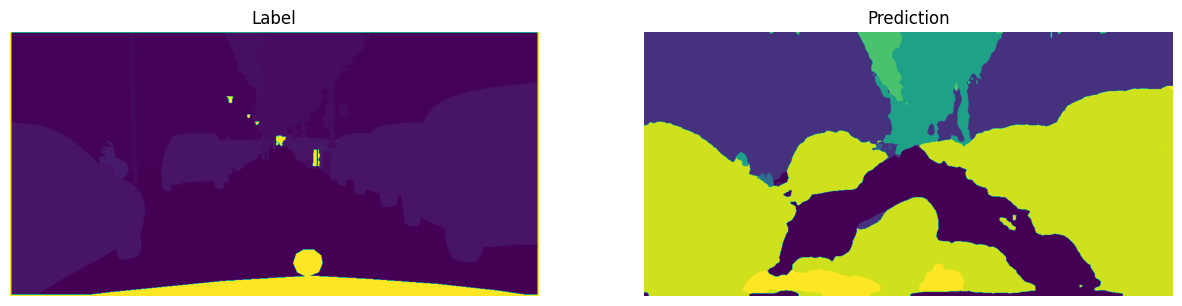

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_gta5.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()